<h1><center>MDI343 / MDI724 - TP1 Avazu<center></h1>

#### For any remark or suggestion, please feel free to contact us at: 
#### pascal.bianchi@telecom-paristech.fr
#### nidham.gazagnadou@telecom-paristech.fr
#### kevin.elgui@gmail.com



## First name : Mohamed
## Last name : DHAOUI
## Email : mohamed.dhaoui@telecom-paristech.fr

##  Introduction

Many ads are actually sold on a "pay-per-click" (PPC) basis, meaning the company only pays for ad clicks, not ad views. Thus your optimal approach (as a search engine) is actually to choose an ad based on "expected value", meaning the price of a click times the likelihood that the ad will be clicked. In other words, a \$1.00 ad with a 5% probability of being clicked has an expected value of \$0.05, whereas a \$2.00 ad with a 1% probability of being clicked has an expected value of only \$0.02. In this case, you would choose to display the first ad.

In order for you to maximize expected value, you therefore need to accurately predict the likelihood that a given ad will be clicked, also known as "click-through rate" (CTR).

In this notebook, We will walk through the predictive modeling process of CTR using AVAZU Dataset 

<font color="red">**Question 0:**
    Import the needed packages: numpy, pandas etc..
</font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix, hstack
import seaborn as sns
from sklearn.preprocessing import  OneHotEncoder
from sklearn.preprocessing import LabelEncoder  
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import roc_curve, auc,roc_auc_score
import datetime
import hashlib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import time
from xgboost import XGBClassifier
from utils import plotlift
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score


############ suppression des warnings ###############

import warnings
warnings.filterwarnings('ignore')
############ plot config              ###############
%matplotlib notebook 
%matplotlib inline
from matplotlib.pyplot import figure


# The dataset

Our dataset comprises of the following features:

    id: ad identifier
    click: 0 for non-click, 1 for click
    hour: in the format of YYMMDDHH
    C1: some anonymized categorical variable e.g. 1002
    banner_pos: where a banner is located, 1 and 0
    site_id: site identifier
    site_domain: hashed site domain
    site_category: hashed site category e.g. 28905ebd
    app_id: mobile app identifier
    app_domain
    app_category
    device_id: mobile device identifier
    device_ip: IP address
    device_model: hashed model e.g. iPhone 6, Samsung
    device_type: hashed device type e.g. tablet, smartphone
    device_conn_type: hashed type of connection e.g. Wi-Fi, 4G
    C14-C21: some more anonymized categorical variables


Let's start by loading the data into a pandas dataframe and exploring it ina python notebook . We will look at basic stats and graphs and then we will do some featres encoding and engineering. Since most of the data was anonymized, we did not have much to refine except for some of the data columns.

<font color="red">**Question 1:**
    Load the data into a pandas DataFrame and display the first lines with the ".head()" method.
    <br>
</font>


In [2]:

################## you need to change th url the train-1000000 ###############

df = pd.read_csv("/home/user/TelecomParistech/Challenge_ML/data/train-1000000") #### reading file

In [3]:
df.head()  #### printing headers

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,3.983206e+18,0,14102915,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,2,4687,320,50,423,2,39,100148,32
1,7.756884e+18,0,14103007,1002,0,cb809abf,74acf31a,50e219e0,ecad2386,7801e8d9,...,0,0,17894,320,50,2039,2,39,100077,32
2,6.941774e+17,0,14102711,1005,0,85f751fd,c4e18dd6,50e219e0,e9739828,df32afa9,...,1,0,22684,320,50,2619,1,163,100055,71
3,2.664154e+18,1,14102903,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,...,1,0,23222,320,50,2676,0,35,100176,221
4,1.480510e+19,0,14102902,1005,1,791b5571,fd13bc73,f028772b,ecad2386,7801e8d9,...,1,0,8330,320,50,761,3,175,100081,23


<font color="red">**Question 2:**
    What is the 'click' frequency in the dataset?
    <br>
</font>

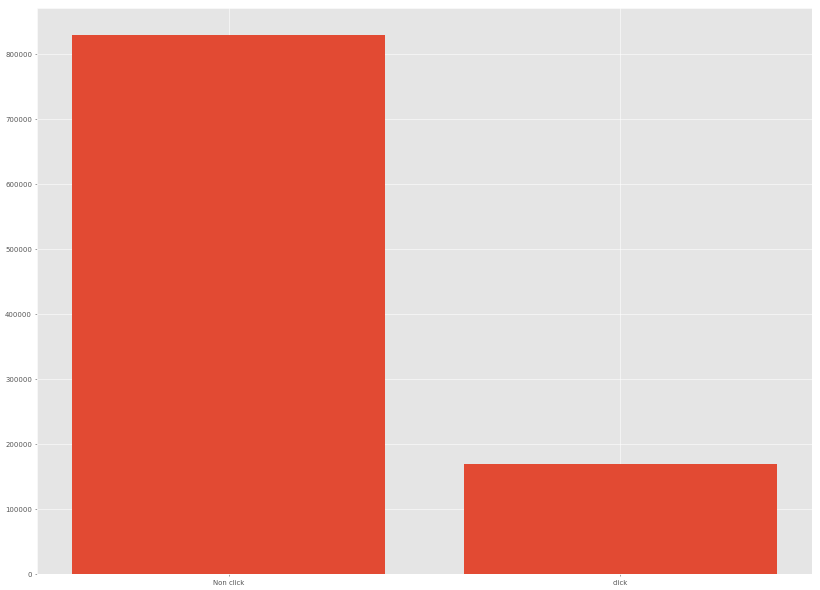

In [4]:


plt.style.use("ggplot")  #### stype of figure
figure(num=None, figsize=(20,15), dpi=50, facecolor='w', edgecolor='k') ### figure custom parameter


# Create bars
plt.bar([0,1], df.click.value_counts().values) ### plot bar
 
# Create names on the x-axis
plt.xticks([0,1], ['Non click','click']) ## put labels
 
# Show graphic
plt.show()  ### inline view

In [5]:
df.click.value_counts()  ### count of click / non click

0    830029
1    169971
Name: click, dtype: int64

We note that the Avazu dataset is very unbalanced. The 'click' class represents less than a fifth of the whole database. We already know that a classifier always predicting 'click'=0 will have good preformances in terms of error rate (around 0.17). The ROC and lift curves will be better performance metrics.

<font color="red">**Question 3:**
    What are the categorical features? Using the 'df.dtypes' method, compute the number of distincts values for each of these features.
</font>

In [6]:
############### 1st method : types of variables using dtype #############"


var_dtypes=pd.DataFrame(df.dtypes)  ### get types of each column and transform to dataframe
var_dtypes=var_dtypes.reset_index() ## resetting index to get var name
var_dtypes.columns=['var','type']  ## renaming columns
print ("Types of variables :")  ### print var
var_dtypes

Types of variables :


,var,type
0,id,float64
1,click,int64
2,hour,int64
3,C1,int64
4,banner_pos,int64
5,site_id,object
6,site_domain,object
7,site_category,object
8,app_id,object
9,app_domain,object


In [7]:

############# Getting categorical variables ,object types and we precize the rest ############

listategorical=var_dtypes[(var_dtypes.type=='object')]["var"].values.tolist() + ['hour','C1','banner_pos','device_type','device_conn_type']+['C'+str(i) for i in [14,15,16,17,18,19,20,21]]
len(listategorical)
print("List of categorical features : ")
listategorical

List of categorical features : 


['site_id',
 'site_domain',
 'site_category',
 'app_id',
 'app_domain',
 'app_category',
 'device_id',
 'device_ip',
 'device_model',
 'hour',
 'C1',
 'banner_pos',
 'device_type',
 'device_conn_type',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C20',
 'C21']

In [8]:
################" var tyepes using count of unique values in each field###########

types_count=pd.DataFrame(df.nunique()).reset_index() ## get count of unique element in each column
types_count.columns=["variable","countocc"] ## renaming dataframe
types_count=types_count[types_count.variable != 'click'] ## removing target
countype_categorical=types_count[types_count.countocc < 1000000]  ### keeping variables having less than the nmber of obs
print("list of categorical with occurences")
countype_categorical

list of categorical with occurences


,variable,countocc
2,hour,240
3,C1,7
4,banner_pos,7
5,site_id,2651
6,site_domain,2871
7,site_category,22
8,app_id,3157
9,app_domain,198
10,app_category,26
11,device_id,150501


Some variable appear to have a very high number of unique values, especially the device-id and the device ip , which suggests the values may be specific to a small number of training examples and could be a candidate for removal to reduce features, as they do not include generalisable information.

<font color="red">**Question 4:**
    If one does a dummy encoding of all categorical variables, what would be the dimension of the model?
    In other words: what would be the dimension of our big feature vector encoded with dummies. 
    <br>
</font>

In [9]:
####  number of featres#####

n_continuous=sum(countype_categorical.countocc.tolist()) ### we use the countocc variablein the previous dataframe
print ( " Nummber of features is : %s"%( n_continuous))

 Nummber of feautures is : 723078


<font color="red">**Question 5:**
    Analyze the 'hour' column: which format is used? How can we transform/simply this feature?
</font>

In [10]:
print("Header of hour column")

df['hour'].head() #### print header

Header of hour column


0    14102915
1    14103007
2    14102711
3    14102903
4    14102902
Name: hour, dtype: int64

The format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC 
If we want to process the date , we need to extract each field separetely 
 * the hour = last two integer
 * the day = integers withe indexes 4 & 5
 * the month = integers with indexes 2 & 3
 * the year = the first tw integers

<font color="red">**Question 6:**
    Run and understand the following script.
</font>

In [11]:
def datesplit(originalDate):
    originalDate = str(originalDate)
    
    year = int("20" + originalDate[0:2])
    month = int(originalDate[2:4])
    day = int(originalDate[4:6])
    hour = int(originalDate[6:8])
    
    return datetime.datetime(year, month, day, hour)

# Exemple :
datesplit(14102915).weekday(), datesplit(14102915).hour

(2, 15)


The scrit extacts the year , the month , the day and the hour from the date column after transforming it into string, then create a datetime object with the extracted entities . 
The example shows how we can extract the weekday and the hour from "14102915"

<font color="red">**Question 7:**
    Using the ".apply( ... )" method, create a 'weekday' for the day of the week. Then, replace the 'hour' column by the hour.
</font>

To answer this question you have to understand that applies takes a function as argument
<br>
"lambda x: ... " is used to create local unamed function of x
<br>
Check the documentation: https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions

In [12]:
df['weekday'] = df["hour"].apply(lambda x:datesplit(x).weekday()).values  #### weekday field
df['hour'] = df["hour"].apply(lambda x:datesplit(x).hour).values ### hour field
df[['hour','weekday']].head() ### print 

,hour,weekday
0,15,2
1,7,3
2,11,0
3,3,2
4,2,2


<font color="red">**Question 8:**
    Using the ".groupby( ... )" method, visualize the influence of the hour and of the day on the 'click' frequency. To do so, plot 'click' vs 'hour' and 'click' vs 'weekday' curves.
</font>

In [13]:
print(df.groupby(by='hour').click.mean().reset_index()) # group click mean by hour 
print(df.groupby(by='weekday').click.mean().reset_index()) # group lick mean by weekday

    hour     click
0      0  0.182707
1      1  0.185734
2      2  0.175552
3      3  0.175367
4      4  0.159664
5      5  0.162126
6      6  0.169315
7      7  0.177490
8      8  0.163418
9      9  0.159042
10    10  0.162613
11    11  0.171025
12    12  0.171659
13    13  0.168032
14    14  0.178075
15    15  0.183737
16    16  0.180076
17    17  0.173271
18    18  0.164072
19    19  0.165725
20    20  0.158402
21    21  0.162384
22    22  0.166847
23    23  0.170733
   weekday     click
0        0  0.183143
1        1  0.161577
2        2  0.158675
3        3  0.173795
4        4  0.173392
5        5  0.183995
6        6  0.183105


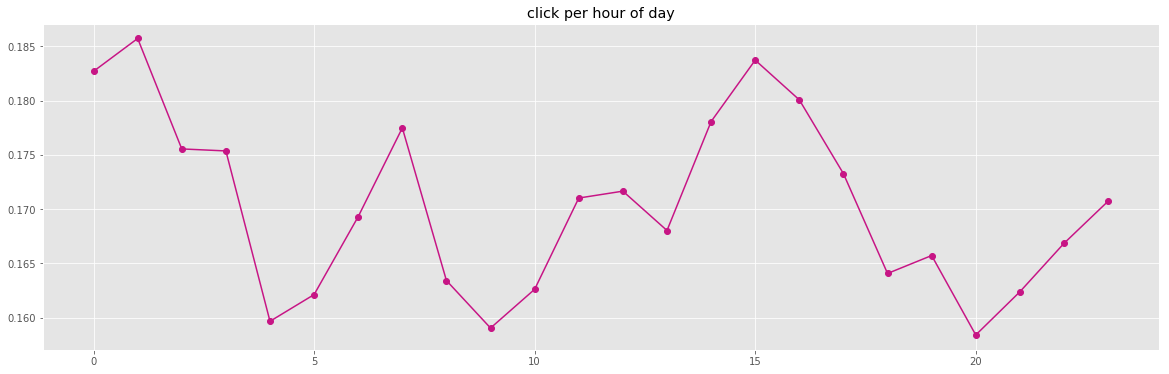

In [14]:
################################### plotting mean click per hour ############################

plt.figure(figsize=(20,6))

data_hours=df.groupby(by='hour').click.mean().reset_index()

# plot hour-click with matplotlib
plt.plot('hour', 'click', data=data_hours, marker='o', color='mediumvioletred')
plt.title("click per hour of day")
plt.show()


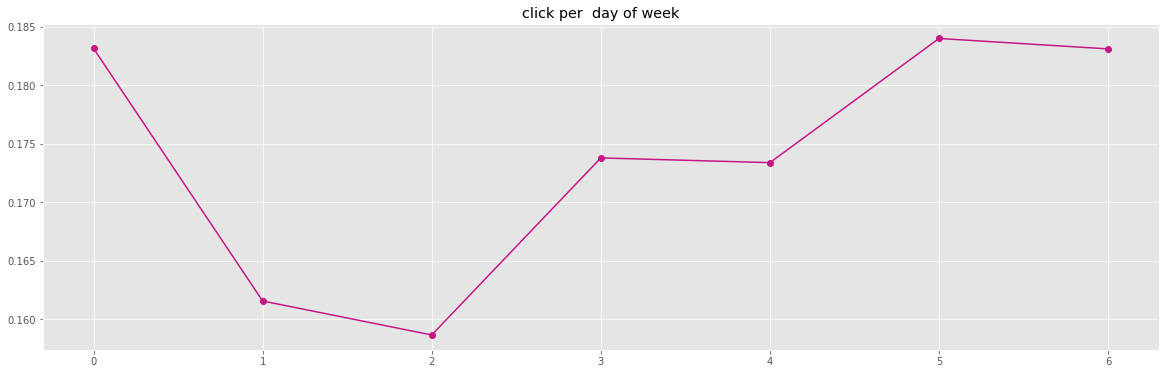

In [15]:
################################### plotting mean click per weekday ############################


plt.figure(figsize=(20,6))

# plot weekday click with matplotlib
data_day=df.groupby(by='weekday').click.mean().reset_index()
plt.plot('weekday', 'click', data=data_day, marker='o', color='mediumvioletred')
plt.title("click per  day of week")
plt.show()

<font color="red">**Question 9:**
    Explain what the axes stand for and try to interpret the shape of the obtained curves.
</font>

In the plots above , we presented the probability of click per hour and per weekday.
Here , we see that the probability of click varies significantly between each hour, with predominant clicks (peaks ) throughout the beginning of morning , in the afternoon and late in  the night . 
The first peak around 7h may corresponds to the time we spend early in the morning either in transportation or during breakfast where people have the time to navigate with their devices . 
The second peak is at the middle of the afternoon where most of people can navigate during their cafe break or work .
The second plot show that the probability of click is higher in the weekend wich is obvious because people  have more time to spend in the internet. 


# Preliminary work and first model

Start by understanding the features with few modalities:
'hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21'.

<font color="red">**Question 10:**
    For instance, inspect the columns 'C15' (dimension of the advert) and 'site_category': visualize the clicks mean.
</font>

Let's plot the mean of click per category of C15

,C15,click
0,120,0.033708
1,216,0.129612
2,300,0.360537
3,320,0.158767
4,480,0.285714
5,728,0.054144
6,768,0.375000
7,1024,0.166667


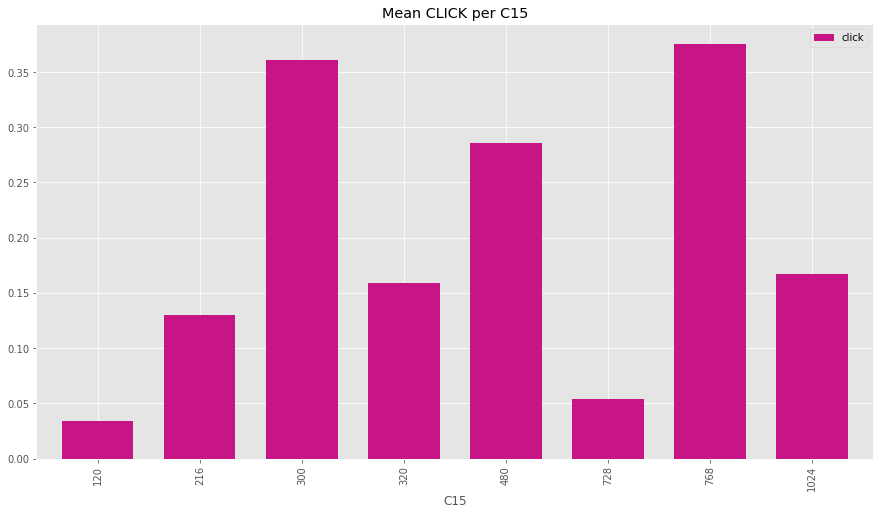

In [16]:
tmp=df.groupby(by='C15').click.mean().reset_index()  ##### mean click per c15
tmp=tmp.pivot_table(index=['C15'], values='click') ### pivoting table tohave categories in columns
tmp.plot.bar(stacked=True, width=0.7, figsize=(15,8), color='mediumvioletred',title="Mean CLICK per C15")## stackplot
df.groupby(by='C15').click.mean().reset_index() ## mean click per c15 modality


The distribution of mean click is quite unbalanced ..We also would like to observe the counts of click and no click for each category of C15

 click or not per dimension of advert - C15  


click,0,1
C15,,
120,86,3
216,6393,952
300,36764,20728
320,784944,148144
480,40,16
728,1712,98
768,30,18
1024,60,12


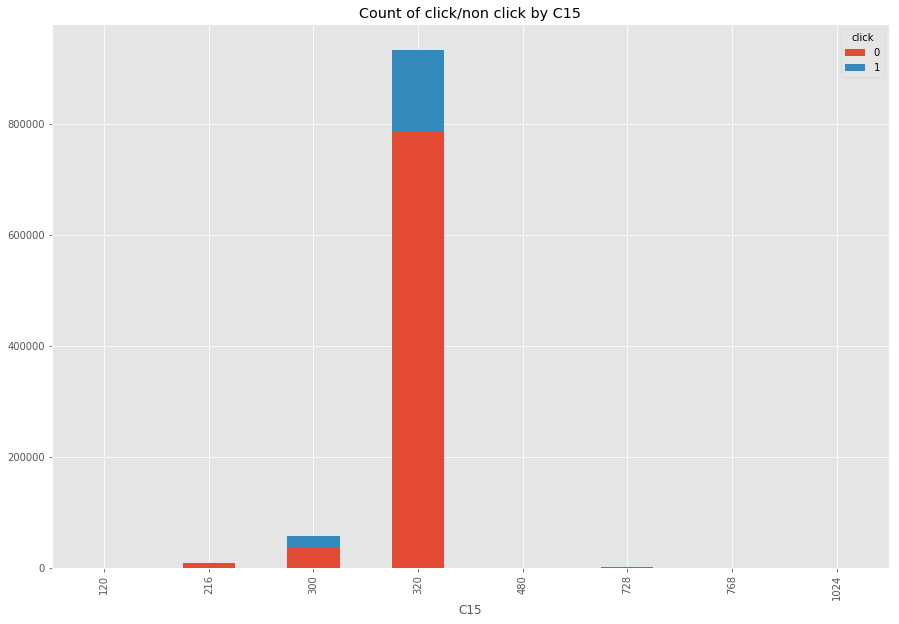

In [17]:

# number of clicks & no clicks by C15
c15_type_table=pd.crosstab(index=df['C15'],columns=df['click'])
print(" click or not per dimension of advert - C15  ")
c15_type_table.plot(kind='bar',figsize=(15,10),stacked=True,title="Count of click/non click by C15")
c15_type_table


Here we see that there are some categories that generate  a high probability of click even if they are a minority in the the dataset ( the category 768  ) , so we need to put more attention to this behaviour in our  modelling

Now let's inspect the click per site category :

,site_category,click
0,0569f928,0.053613
1,28905ebd,0.208076
2,335d28a8,0.089824
3,3e814130,0.284245
4,42a36e14,0.225806
5,50e219e0,0.128597
6,5378d028,0.000000
7,70fb0e29,0.144737
8,72722551,0.059172
9,75fa27f6,0.111305


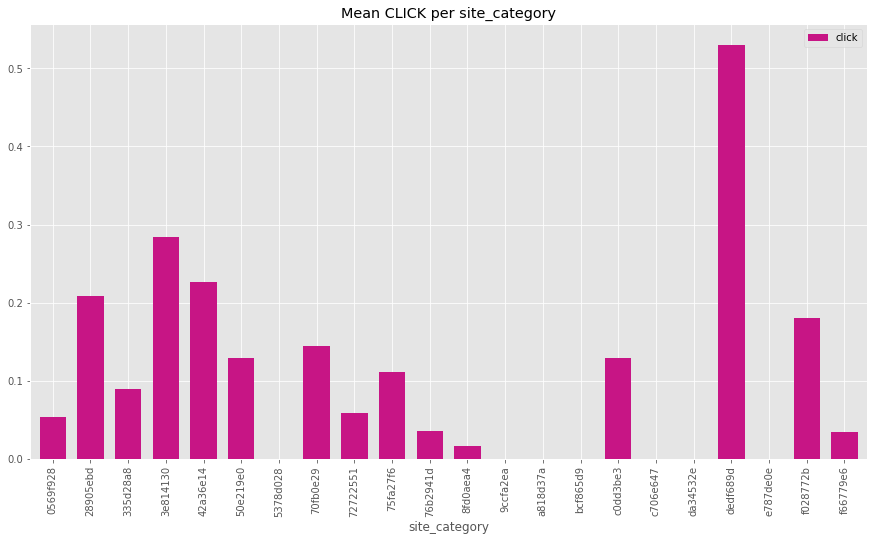

In [18]:
tmp=df.groupby(by='site_category').click.mean().reset_index()  ### mean click per site-category
tmp=tmp.pivot_table(index=['site_category'], values='click') ### pivoting table
tmp.plot.bar(stacked=True, width=0.7, figsize=(15,8), color='mediumvioletred',title="Mean CLICK per site_category") ## plot
df.groupby(by='site_category').click.mean().reset_index()  ### displaying the table


We observe that there are some site categories that generate more clicks than others . Unfortunately , this variable was hashed so we cannot exxplain the plot above . Let's plot the counts of click and no click for each site category

####click or not per site category####


click,0,1
site_category,,
0569f928,406,23
28905ebd,144146,37874
335d28a8,3050,301
3e814130,54159,21508
42a36e14,48,14
50e219e0,356335,52586
5378d028,11,0
70fb0e29,520,88
72722551,636,40


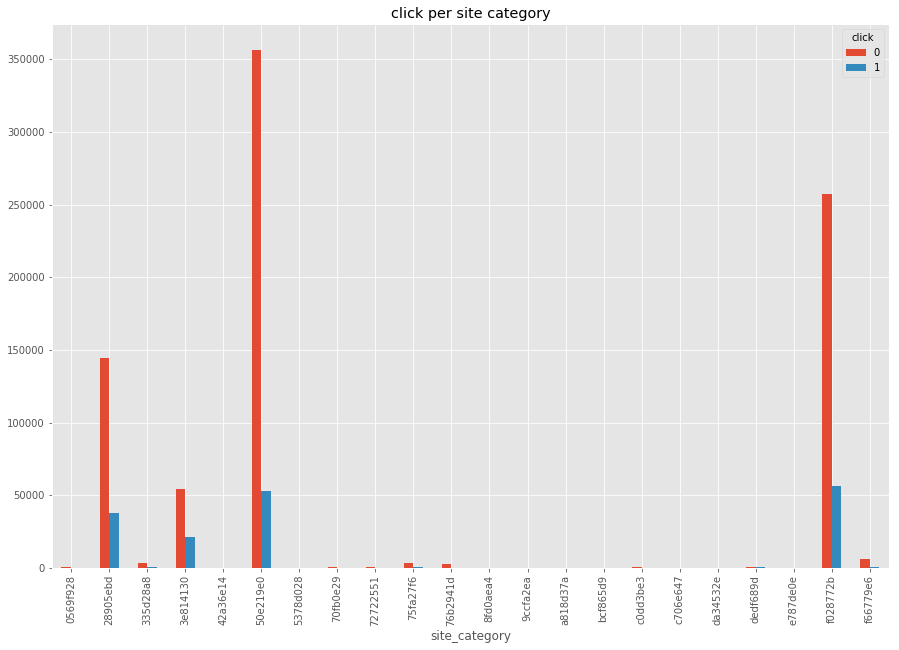

In [19]:
site_type_table=pd.crosstab(index=df['site_category'],columns=df['click'])  #### mean click per site-category
print("####click or not per site category####")
site_type_table.plot(kind='bar',figsize=(15,10),stacked=False) ## stack plot
plt.title("click per site category")
site_type_table ### stack table

<font color="red">**Question 11:**
    Some site categories have a null click rate. Why? Display the 'count()' of each modality.
    <br><br>
    Hint: you can use the method ".value_counts()"
</font>

In [20]:
df.site_category.value_counts()  ###number of obs per site_category

50e219e0    408921
f028772b    313339
28905ebd    182020
3e814130     75667
f66779e6      6365
75fa27f6      4007
335d28a8      3351
76b2941d      2573
c0dd3be3      1026
72722551       676
dedf689d       624
70fb0e29       608
0569f928       429
8fd0aea4       189
a818d37a        81
42a36e14        62
e787de0e        28
bcf865d9        16
5378d028        11
9ccfa2ea         5
da34532e         1
c706e647         1
Name: site_category, dtype: int64

We can imagine that some sites categories like websites for military or research institutions does not generate a good web trafic and could have a very low click rate .
Besides ,  many websites ,like personal blog , are not well referenced in the net , do not run ADS in their sites and do not have invested yet in their e-reputation and their digital marketing development . These websites could have also a low click rate. 

In [21]:
col = 'C1' #### the column to inspect
a = pd.DataFrame([df.groupby(col).mean()['click'], df.groupby(col).count()['click']]).transpose() ## datframe mean count per col
a.columns = ['mean', 'count'] ## renamin
a.sort_values(by='count', ascending=False) ## sorting

,mean,count
C1,,
1005,0.169474,918606.0
1002,0.211157,54907.0
1010,0.095497,22409.0
1012,0.177295,2854.0
1007,0.035591,871.0
1001,0.027027,222.0
1008,0.106870,131.0


Here we can observe that the mean click vary depending on C1 category , so it could be an important variable in our modelling

<font color="red">**Question 12:**
    Divide the dataset into a training (90%) and test set (10%) with sklearn (use the following option: random_state=100).
</font>

In [22]:
X_train_b=df.drop('click',axis=1) ### dropping the target
y_train_b=df['click'] ### get the target

Xtrain, Xtest, ytrain, ytest = train_test_split(X_train_b, y_train_b, test_size=0.1, random_state=100)

In [23]:
print("Train shape {%s,%s}" %Xtrain.shape)
print("Test shape {%s,%s}" %Xtest.shape)

Train shape {900000,24}
Test shape {100000,24}


# First work on a reduced number of features

<font color="red">**Question 13:**
    Put in a list the selected columns: 'hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21'.
</font>

In [24]:
some_columns = ['hour','weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 
                'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21']  ### list of useful cols

Let's select only the subset of columns in the test  and the train dataset

In [25]:
X_train=Xtrain[some_columns] ## subcol of train
X_test=Xtest[some_columns] ## subcol of test
y_train=ytrain ## train target...

In [26]:
############ printing the new shapes ############""

print("Train new shape {%s,%s}" %X_train.shape)
print("List of selected columns : ")
print(X_train.columns)


Train new shape {900000,12}
List of selected columns : 
Index(['hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category',
       'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21'],
      dtype='object')


<font color="red">**Question 14:**
    <br>
    - Import OneHotEncoder from sklearn.preprocessing
    <br>
    - Transform the training and the test data restricted to the selected columns
    <br>
    - Give the type of the outputs.
</font>

The Onehoteencoder is imported at the begining of the notebook .
Before start encoding , let's recall the number of modalities in each variable 


In [27]:
temp=pd.DataFrame(Xtrain[some_columns].nunique()).reset_index() ### recall the numbe of modalities in eah var
temp.columns=["variable","countmod"] ### renaming temp
print("Sum of features is %s " % sum(temp.countmod)) ### sum of all features
temp

Sum of features is 183 


,variable,countmod
0,hour,24
1,weekday,7
2,C1,7
3,banner_pos,7
4,site_category,22
5,app_category,26
6,device_type,5
7,device_conn_type,4
8,C15,8
9,C16,9


Features Site_category and App_category are hashed and we need to use labelencoder before performing the one hot encoding .
The other variables are represented as integers hence we make use directly of one hot encoding to deal with these features .

In [28]:

######## label encoding train  : fit_transfom
le_app = LabelEncoder()
x=le_app.fit_transform(X_train[['app_category']])
pd.DataFrame(x).nunique()
X_train.app_category=x

le_site = LabelEncoder()
x=le_site.fit_transform(X_train[['site_category']])
X_train.site_category=x


######### label encoding test  : transform only
le = LabelEncoder()
x=le_app.transform(X_test[['app_category']])
X_test.app_category=x

x=le_site.transform(X_test[['site_category']])
X_test.site_category=x

In [29]:
print("Train data after label encoding  : ")
X_train.head()

Train data after label encoding  : 


,hour,weekday,C1,banner_pos,site_category,app_category,device_type,device_conn_type,C15,C16,C18,C21
92438,10,0,1010,1,5,3,4,3,320,50,0,79
60898,22,1,1005,0,5,25,1,2,320,50,0,79
556199,4,0,1005,0,20,0,1,2,320,50,0,182
193129,12,1,1005,1,20,0,1,0,320,50,0,48
231985,13,6,1005,0,1,0,1,0,320,50,0,79


In [30]:
################################### One hot encoding ########################################
ohe = OneHotEncoder(handle_unknown='ignore')  ### define onhotencoder with ignore option
ohe.fit(X_train) ### fitting the onehot encoder
Xtrain_oh = ohe.transform(X_train)# fit & transformation of Xtrain restricted to selected columns
Xtest_oh = ohe.transform(X_test)#  transformation of Xtrain restricted to selected columns

In [31]:
print(Xtrain_oh.shape)
print(Xtest_oh.shape)

(900000, 183)
(100000, 183)


In [32]:
print("Data after one hot encoding : ")
pd.DataFrame(Xtrain_oh.toarray()).head() ## header of the encoded dataframe

Data after one hot encoding : 


,0,1,2,3,4,5,6,7,8,9,...,173,174,175,176,177,178,179,180,181,182
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


After one hot encoding , we have only binary columns :  We got k binary variables for each original variable containing k modalities .


<font color="red">**Question 15:**
    What is the new number of features?
</font>

In [33]:
print("the new number of feature is %s" %Xtrain_oh.shape[1])

the new number of feature is 183


<font color="red">**Question 16:**
    Visualize the first row of the design matrix you have got.
</font>

In [34]:
Xtrain_oh.toarray()[1] ### first row

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

<font color="red">**Question 17:**
    Import and fit a logistic regression model on your the encoded data
</font>

Let's start by a simple model : the logistic regression with LBFGS as a solver 

In [35]:
####################################### fitting logistsitc regression  ##########
start_time = time.time()

lr =LogisticRegression(random_state=0, solver='lbfgs') #### initialze classifier
lr.fit(Xtrain_oh, y_train) ### fitting classifier

end_time = time.time()

time_lr_1=(end_time - start_time)


The logistic regression takes only a few seconds to train which is quite impressive if we take into account the number of observations 

<font color="red">**Question 18:**
    With '.predict' and 'predict_proba', display the hard and soft decision you get on test data.
</font>

In [36]:
hard =lr.predict(Xtest_oh) #### hard prediction : labels
soft = lr.predict_proba(Xtest_oh) ### soft prediction : probas

print("hard (classes ) : ",hard)
print("soft ( probabilities ) : ", soft)

hard (classes ) :  [0 0 0 ... 0 0 0]
soft ( probabilities ) :  [[0.75870943 0.24129057]
 [0.73401057 0.26598943]
 [0.79796849 0.20203151]
 ...
 [0.79173663 0.20826337]
 [0.78450372 0.21549628]
 [0.87964682 0.12035318]]


<font color="red">**Question 19:**
    Compute the probability of **error** using sklearn.metrics 'accuracy_score' function. Comment.
    
</font>

In [37]:
print( "The accuracy score of the logistic regression model is %.2f%%" %accuracy_score(ytest, hard))

The accuracy score of the logistic regression model is 0.83%


That's not bad at all for a first simple model  , But did we use the best metric to evaluate the model ? Let's check more sophisticated metrics


<font color="red">**Question 20:**
    Which sklearn.metrics could you also use?
</font>

There are many metrics to measure the performance of classifier . For our problem, we would want to evaluate the model by comparing the predicted probabilities versus the actual target values, using an appropriate "evaluation metric." The best metric to use in this case is probably logarithmic loss, which is commonly used when we care about having well-calibrated probabilities. In addition, we might inspect the ROC curve and compute other metrics such as AUC. In this lab , we will use the Log-Loss and the AUC under ROC

<font color="red">**Question 21:**
    Plot the ROC curve. Then compute the log loss and the Area Under the Curve ROC.
</font>

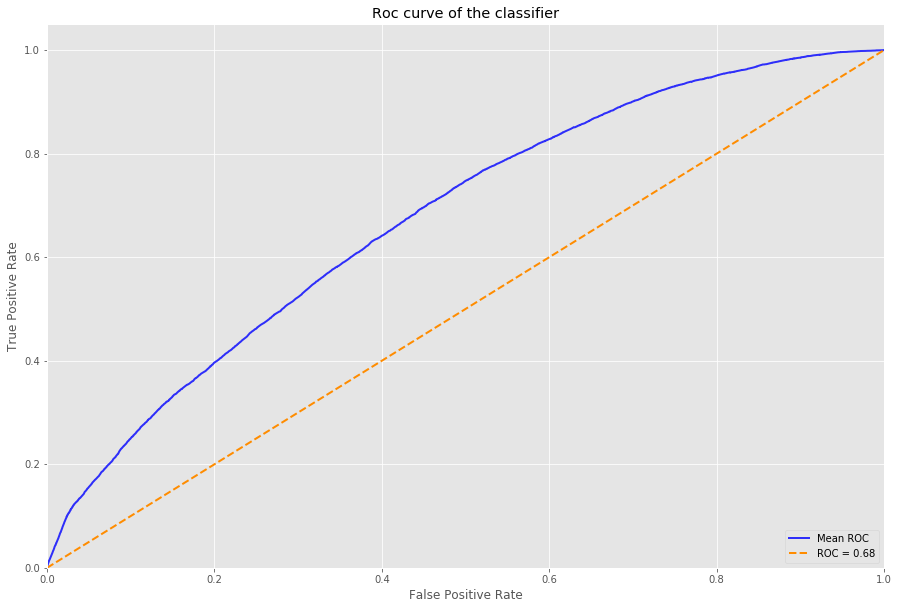

In [38]:
####################################### plotting the roc curve ##############################
plt.figure(figsize=(15,10)) ### customize the size

fpr, tpr, thresholds = roc_curve(ytest,soft[:,1]) #### getting fpr and tpr
roc_auc =auc(fpr, tpr)

plt.plot(fpr, tpr, color='b',
         label=r'Mean ROC',
         lw=2, alpha=.8)

#### customizing axes ##############
plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--',label='ROC = %0.2f' % roc_auc_score(ytest, soft.T[1]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve of the classifier')
plt.legend(loc="lower right")
plt.show()


In [39]:
print ("The log loss is %.2f%%" % (100*log_loss(ytest,soft[:,1])))
print ("The roc auc score is %.2f%%" % (100*roc_auc_score(ytest, soft[:,1])))


#### save the results for ulterior comparaisoon

logloss_lr_1 =log_loss(ytest, soft) #### keep track of the logloss
auc_lr_1=roc_auc_score(ytest, soft[:,1]) #### keep track oof the auc

The log loss is 42.52%
The roc auc score is 67.62%


As we can see , the score depends a lot on the metric we use and the difference is quite significant between auc ,  accuracy score and log-loss . These metrics can be used to compare between different models . 
In my opinion , I think that the AUC  or the logloss are the most robust metrics to measure the performance of a classifier as it takes into account the different possible threshhold whle computing the False Positives and the True Positives .

<font color="red">**Question 22:**
    <br>
    - Import the 'plot_lift' function from 'utils.py' and plot the lift curve. What is the lift of the first fifth of the population identified by the test?
    <br>
    -  Interpret it. 
</font>

Text(0.5,1,'The lift curve of the classifier ')

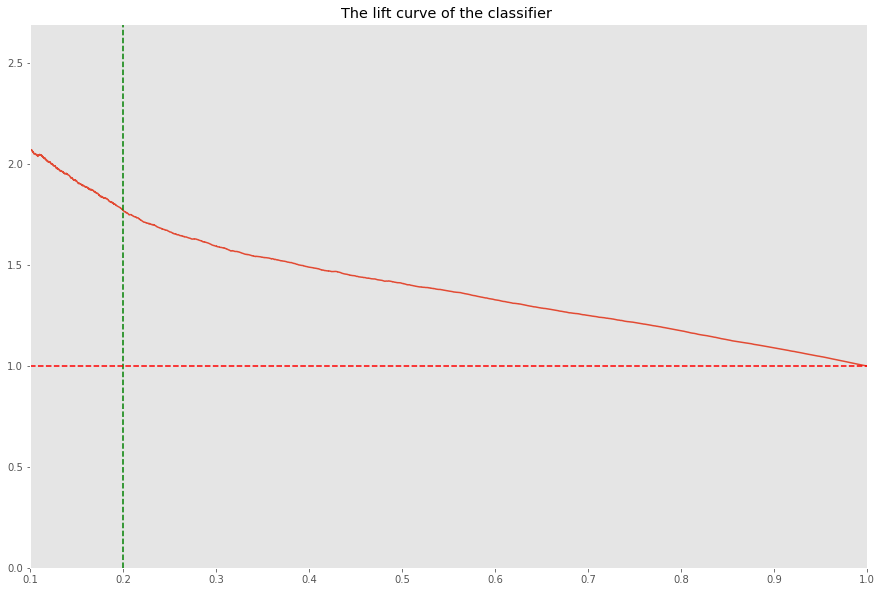

In [40]:
###### ###############" plot lift curve #############" ######
plt.figure(figsize=(15,10))
plt.style.use("ggplot")
plotlift(ytest, soft.T[1])
# The following line just plots a vertical line for you to answer the second part of the question
plt.axvline(x= 0.2 , linestyle='--', color='g')
plt.axhline(y= 1 , linestyle='--', color='r');
plt.title("The lift curve of the classifier ")

We plot a lift curve to describe the classification performance of a LogisticRegression classifier .
Here , we measure the performance of the algorithm comparing to random model while increasing the number sample size from 0% to 100 % .The greater the area between the lift curve and the baseline, the better the model.
One more detail ,we can have an idea about the convergence speed of algorithm ( in term of samples ) through the lift curve ( the X axis is the %  of sample used ) .But we need  to say that lift charts are not a good way to evaluate a model (as it cannot be used for comparison between models), and are instead a means of evaluating the results where your resources are finite.



# Complete model

In [41]:
df.head() ##### recalling the data

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday
0,3.983206e+18,0,15,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,2,4687,320,50,423,2,39,100148,32,2
1,7.756884e+18,0,7,1002,0,cb809abf,74acf31a,50e219e0,ecad2386,7801e8d9,...,0,17894,320,50,2039,2,39,100077,32,3
2,6.941774e+17,0,11,1005,0,85f751fd,c4e18dd6,50e219e0,e9739828,df32afa9,...,0,22684,320,50,2619,1,163,100055,71,0
3,2.664154e+18,1,3,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,...,0,23222,320,50,2676,0,35,100176,221,2
4,1.480510e+19,0,2,1005,1,791b5571,fd13bc73,f028772b,ecad2386,7801e8d9,...,0,8330,320,50,761,3,175,100081,23,2


As an example, we now work on the 'site_id' column.
<font color="red">**Question 23:**
    <br>
    - For each modality, compute the number of occurrences in the dataset and the average of clicks for this modality 
    <br>
    - With 'sns.joiplot', represent the set of points (count, mean) for each modality
</font>

In [42]:
### compute number of occurences and mean per site id
df[['site_id','click']].groupby(by='site_id').agg(['count','mean'])


click          
         count      mean
site_id                 
00255fb4     6  0.000000
006ab81e     5  0.000000
00b73968     1  1.000000
00f5367d     2  0.000000
00f648b7    23  0.260870
00f7c6fc     3  0.000000
0114bb39     3  0.000000
011b0fda     1  0.000000
011e5414    35  0.342857
0126d590     1  0.000000
01270328   185  0.237838
0129a661     4  0.250000
013e516e     1  0.000000
014428c1    16  0.125000
015cc1dc     2  0.000000
019de78a     2  0.500000
01da43f6     1  1.000000
01e319df     1  0.000000
021ba5c7     1  0.000000
021cd138   164  0.365854
0222f9ee     1  0.000000
02296256     6  0.166667
0234a6fa    21  0.571429
023f3644   178  0.028090
02546dd5    23  0.000000
02610967     1  0.000000
0273c5ad   141  0.106383
028f551e     1  0.000000
0295efc0     1  0.000000
02a66025    22  0.090909
...        ...       ...
fe7d2ab4    11  0.000000
fe8cc448   297  0.043771
fe8ea44c     1  1.000000
fe918eeb     1  0.000000
fe9c7f90     1  0.000000
feb793b0     4  0.000000
fec6e632  1604  0.132170
fed1a009     3  0.333333
fee8da23     5  0.000000
fefe6fb9    48  0.208333
ff0784fb     4  0.750000
ff108d09     6  0.000000
ff18c3d1   280  0.307143
ff1b88b6     3  0.000000
ff1bcc6f    51  0.254902
ff255427     1  0.000000
ff361da0   543  0.101289
ff4425e5     4  0.000000
ff55c4ea     9  0.000000
ff61c6a9   103  0.174757
ff719d0c     4  0.000000
ff9bcf52     4  0.000000
ff9d066a    34  0.088235
ffa0a3ef     7  0.285714
ffad33d9     3  0.333333
ffb2c209   120  0.100000
ffc6e801     4  0.500000
ffcb6b9a   180  0.161111
ffcff165    21  0.142857
fffe8e1c     6  0.166667

[2651 rows x 2 columns]

<Figure size 1440x432 with 0 Axes>

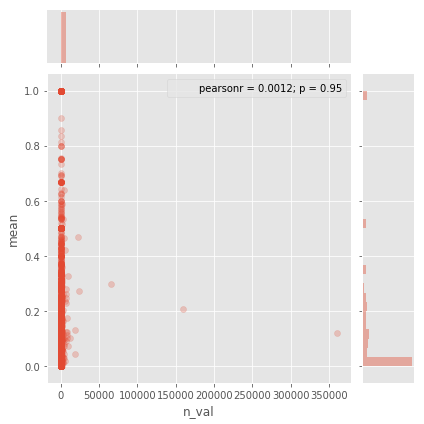

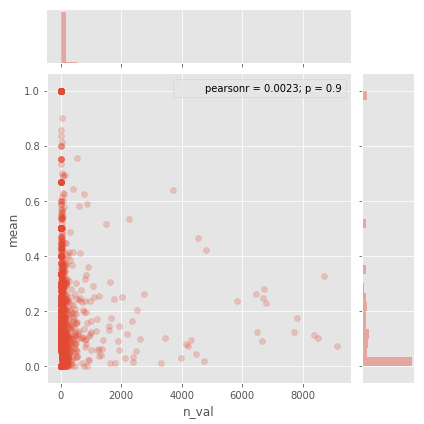

In [43]:
################################## plot count mean for each modalities ###########""
plt.figure(figsize=(20,6))
col = 'site_id'
a = pd.DataFrame([df.groupby(col).mean()['click'], df.groupby(col).count()['click']]).transpose()
a.columns = ['mean', 'n_val']
sns.jointplot(a['n_val'], a['mean'], alpha=0.25);
thres = 10000
sns.jointplot(a[a['n_val']<thres]['n_val'], a[a['n_val']<thres]['mean'], alpha=0.25);
#sns.jointplot(a[a['n_val']<thres]['n_val'], a[a['n_val']<thres]['mean'], alpha=0.9);

<font color="red">**Question 24:**
    In the above commands, what does the alpha parameter stand for?
</font>

The alpha parameter controls the density of color of observations ( transparency ), the more we distance from the mean , the more the density of color diminue


Several sites with a lot of occurrences in the dataset have a click frequency very different from the mean. It is relevant to keep the column 'site_id' at least for the modalities for which 'count' is very high.


<font color="red">**Question 25:**
    Do the same work on the 'device_id' column. What do you notice? What could be the isolated point?
</font>

In [44]:
df[['device_id','click']].groupby(by='device_id').agg(['count','mean']) ###the same as the site category


click     
          count mean
device_id           
00000919      1  0.0
0000194a      1  1.0
000070cc      1  0.0
00012342      1  0.0
0001515a      1  1.0
00017304      1  0.0
0001edc1      1  1.0
00027d63      1  1.0
0002a816      1  0.0
00030b6d      1  0.0
00030d45      1  0.0
00038618      2  0.0
0003a1f5      1  0.0
0003e74f      1  0.0
00057dc5      1  0.0
00058d01      1  0.0
0005ad82      1  0.0
0006676e      1  0.0
0007b36d      1  0.0
000817d8      2  0.0
00083085      1  1.0
000838b9      1  0.0
00089a9c      2  0.5
00097739      1  0.0
000994a0      1  1.0
0009b88e      1  0.0
000a0e4c      1  0.0
000a51d6      1  1.0
000a8399      1  0.0
000a9070      1  0.0
...         ...  ...
fff40d34      1  0.0
fff43563      2  0.0
fff46785      1  0.0
fff4bd93      1  0.0
fff4e647      1  0.0
fff52a52      1  1.0
fff543d0      1  1.0
fff57d1d      1  0.0
fff6c47b      1  0.0
fff735d8      1  1.0
fff74754      1  0.0
fff7bba5      1  1.0
fff8b415      1  0.0
fff8f0a1      1  0.0
fff93cb4      1  0.0
fffa2f21      1  0.0
fffaac6d      3  0.0
fffb0699      1  0.0
fffb6698      1  0.0
fffbc5bb      1  0.0
fffc305e      1  1.0
fffc33d1      1  0.0
fffca6a5      2  1.0
fffcea00      1  0.0
fffd3aa8      1  0.0
fffdf33e      1  0.0
fffe3ef0      1  0.0
fffe5cb4      1  0.0
fffe9672      1  0.0
ffffd98b      2  0.5

[150501 rows x 2 columns]

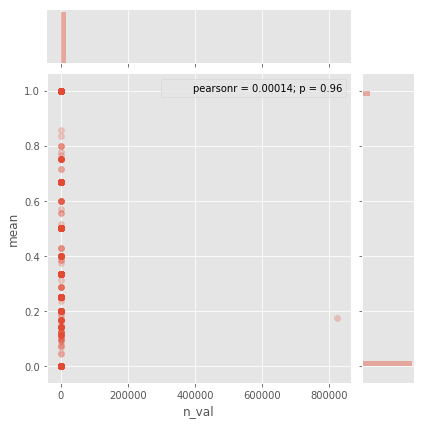

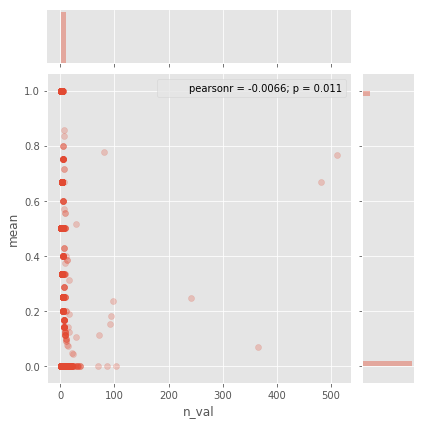

In [45]:
col = 'device_id'

a = pd.DataFrame([df.groupby(col).mean()['click'], df.groupby(col).count()['click']]).transpose()
a.columns = ['mean', 'n_val']
sns.jointplot(a['n_val'], a['mean'], alpha=0.25);
thres = 10000
sns.jointplot(a[a['n_val']<thres]['n_val'], a[a['n_val']<thres]['mean'], alpha=0.25);

There is a device ID that was highly used compared to the other devices ,it can be a robot or an automated script , So we need to isolte such outlier

In [46]:
############ gettng the device_id having the highest count ############
df_device=df[['device_id','click']].groupby(by='device_id').agg(['count','mean']) ###get mean & count per devie
df_device.columns = ["_".join(x) for x in df_device.columns.ravel()]
device_weird=df_device.sort_values(by="click_count", ascending=False).index[0]
print("The device that need to be isolated is %s" %device_weird)

The device that need to be isolated is a99f214a


<font color="red">**Question 26**:   
    In the column df['device_id'], spot the value V corresponding to the largest number of 'count' (using '.value_counts' method). Create a new column df['user'] defined as follows:
</font>
$$
\text{user} = \left\{\begin{array}[h]{ll} \text{device_ip + device_model} & \text{if device_id = V}\\ \text{device_id} & \text{else.}\end{array}\right.
$$

In [47]:

df_device=df[['device_id','click']].groupby(by='device_id').agg(['count','mean'])## prepare count mean click per device
df_device.columns = ["_".join(x) for x in df_device.columns.ravel()]
V=df_device.sort_values(by="click_count", ascending=False).index[0]#### we sort the data by click  count
df_new=df.copy() ## create a copy in case of
df_new['user'] =df_new.device_id ## initalize the column user with device id
df_new.user[df_new.device_id==V]=df_new.device_ip[df_new.device_id==V]+df_new.device_model[df_new.device_id==V] ##update in device-id =V
df_new.head(10)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C14,C15,C16,C17,C18,C19,C20,C21,weekday,user
0,3.983206e+18,0,15,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,4687,320,50,423,2,39,100148,32,2,fb6566d3be87996b
1,7.756884e+18,0,7,1002,0,cb809abf,74acf31a,50e219e0,ecad2386,7801e8d9,...,17894,320,50,2039,2,39,100077,32,3,9b7af851
2,6.941774e+17,0,11,1005,0,85f751fd,c4e18dd6,50e219e0,e9739828,df32afa9,...,22684,320,50,2619,1,163,100055,71,0,748e298a3c55fad5
3,2.664154e+18,1,3,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,...,23222,320,50,2676,0,35,100176,221,2,a50da3d4c5cc73c1
4,1.480510e+19,0,2,1005,1,791b5571,fd13bc73,f028772b,ecad2386,7801e8d9,...,8330,320,50,761,3,175,100081,23,2,d5f88679a5bce124
5,1.591127e+19,0,0,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,...,21611,320,50,2480,3,297,100111,61,0,189590f92ea4f8ba
6,4.149473e+18,0,8,1010,1,85f751fd,c4e18dd6,50e219e0,03a08c3f,7801e8d9,...,15704,320,50,1722,0,35,100084,79,4,192d98b0
7,1.085379e+19,0,4,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,...,23224,320,50,2676,0,35,100176,221,2,342b6e9ea0f5f879
8,2.629918e+18,0,13,1010,1,85f751fd,c4e18dd6,50e219e0,8486dd4e,7801e8d9,...,17875,320,50,2036,3,47,-1,156,5,50dc7a55
9,1.419062e+19,0,0,1010,1,85f751fd,c4e18dd6,50e219e0,04f2be5f,7801e8d9,...,22552,320,50,2602,0,163,100084,182,6,feb99a64


<font color="red">**Question 27**:
    Drop the following columns: 'device_id','device_model','device_ip'
</font>

In [48]:
##################### dropping columns #############

df_new=df_new.drop('device_id',axis=1)
df_new=df_new.drop('device_model',axis=1)
df_new=df_new.drop('device_ip',axis=1)

<font color="red">**Question 28**:
    One could look at the similarity between 'site_id' and 'site_domain'. Merge those columns into a new 'site' column and delete the old 'site_id' and 'site_domain' columns.
</font>

In [49]:
df_new['site']=df_new.site_id+df_new.site_domain ### create site variable

In [50]:
#######""" dropping site_id and site_domain #############"""
df_new=df_new.drop('site_id',axis=1)
df_new=df_new.drop('site_domain',axis=1)

In [51]:
df_new.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_category', 'app_id',
       'app_domain', 'app_category', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'weekday', 'user',
       'site'],
      dtype='object')

<font color="red">**Question 29**:
    Once again, split the modified DataFrame df into a train (90%) and a test set (10%) (with option: random_state = 100).
</font>

In [52]:
########### set index ##########""
df_new=df_new.set_index('id')


In [53]:
###################################### labbel encoding ################################

df_new.C20[df_new.C20==-1]=99999999 ### label encoder does not accept -1

######## label encoding train
le_app = LabelEncoder()
x=le_app.fit_transform(df_new[['app_category']].astype(str))
df_new.app_category=x

le_site = LabelEncoder()
x=le_site.fit_transform(df_new[['site_category']].astype(str))
df_new.site_category=x

le_appid = LabelEncoder()
x=le_appid.fit_transform(df_new[['app_id']].astype(str))
df_new.app_id=x

le_appdomain = LabelEncoder()
x=le_appdomain.fit_transform(df_new[['app_domain']].astype(str))
df_new.app_domain=x

le_user= LabelEncoder()
x=le_user.fit_transform(df_new[['user']].astype(str))
df_new.user=x

le_site = LabelEncoder()
x=le_site.fit_transform(df_new[['site']].astype(str))
df_new.site=x

In [54]:
##################################  test train split ####################################

X_train_b=df_new.drop('click',axis=1)
y_train_b=df_new['click']
Xtrain, Xtest, ytrain, ytest = train_test_split(X_train_b, y_train_b, test_size=0.1, random_state=100)
print("Train shape {%s,%s}" %Xtrain.shape)
print("Test shape {%s,%s}" %Xtest.shape)

Train shape {900000,20}
Test shape {100000,20}


In [55]:
Xtrain.head()

,hour,C1,banner_pos,site_category,app_id,app_domain,app_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday,user,site
id,,,,,,,,,,,,,,,,,,,,
3.406845e+18,10,1010,1,5,928,90,3,4,3,15703,320,50,1722,0,35,99999999,79,0,405125,2901
1.598544e+19,22,1005,0,5,1742,24,25,1,2,15703,320,50,1722,0,35,99999999,79,1,70870,2901
1.792626e+19,4,1005,0,20,2911,90,0,1,2,22553,320,50,2602,0,163,99999999,182,0,485087,402
8.452958e+18,12,1005,1,20,2911,90,0,1,0,19772,320,50,2227,0,935,100075,48,1,607155,2887
1.640144e+19,13,1005,0,1,2911,90,0,1,0,15708,320,50,1722,0,35,100084,79,6,441799,665


<font color="red">**Question 30**:
    Define a OneHotEncoder and then, 'fit_transform' the train set.
</font>

In [56]:

####################################### onehot encoding #################################
ohe = OneHotEncoder(handle_unknown='ignore')
Xtrain_oh = ohe.fit_transform(Xtrain) # Fill here

In [57]:
Xtrain_oh.shape

(900000, 713334)

<font color="red">**Question 31**:
    Transform the test set. If an error occurs, analyze it and try to solve it. Which argument did you set ?
</font>

In [58]:

Xtest_oh = ohe.transform(Xtest) # and transform Xtest restricted to selected columns




The number of categorical values for many variables is relatively high , so the test set could regroup some modalities that did not exist in the train . We used  handle_unknow='ignore' to ignore the new modalities

<font color="red">**Question 32**:
    What is the new number of features?
</font>

In [59]:
print("The number of features is %s"%Xtest_oh.shape[1])

The number of features is 713334


<font color="red">**Question 33**:
    How many modalities have been seen more than a 100 times?
</font>

In [60]:
# The following 'n_ones' vector below gives the number of '1' in each column/modality of the Xtrain_oh design matrix.
n_ones = np.array(Xtrain_oh.sum(axis=0))
listcount1=n_ones[0]
print("The number of modalities is %s" %sum(listcount1>100))

The number of modalities is 1971


We have 1971 modalities that were seen more that a 100 times which is relatively low comparing the number of features we have .

The list 'cols_to_keep' below is used to store the indices of the modalities seen more than a 100 times. You can notice the use of the 'enumerate' function.

In [61]:
useful=list(map(lambda x:x> 100,listcount1.tolist())) ### useful columns
cols_to_keep=[i for i, x in enumerate(useful) if x] ### what columns to keep


<font color="red">**Question 34**:
    Using only our restriction on the 'cols_to_keep' columns, retrain a logistic regression model and compare its performance in terms of 'log_loss' and 'roc_auc_curve'.
</font>

In [63]:

start_time = time.time()
#################################### Fitting LR ########################################
Xtrain_oh_res=Xtrain_oh[:,cols_to_keep] ###### restrict the number of cols
lrmodel =LogisticRegression(random_state=0, solver='lbfgs')
lrmodel.fit(Xtrain_oh_res, np.array(ytrain))


end_time = time.time()

time_lr_new=(end_time - start_time)


In [64]:
################################### evaluting usng auc and logloss#################""
hard =lrmodel.predict(Xtest_oh[:,cols_to_keep])
soft = lrmodel.predict_proba(Xtest_oh[:,cols_to_keep])

print("The log loss of the new logistic regression is %.2f" %log_loss(ytest, soft[:,1]))
print("The auc of the new logistic regression is %.2f" %roc_auc_score(ytest, soft[:,1]))
log_loss_lr_new=log_loss(ytest, soft[:,1])
auc_lr_new=roc_auc_score(ytest, soft[:,1])

The log loss of the new logistic regression is 0.40
The auc of the new logistic regression is 0.74


Based on the auc metric , we have enhanced a bit the performance of  model affter adding the new variables . 
Let's try more advanced models

# Gradient Boosting Decision Trees

<font color="red">**Question 35**:
    <br>
    - Import GradientBoostingClassifier from scikit learn. 
    <br>
    - Initialize it using 50 estimators and a learning rate of 0.8. Set 'verbose=True' to monitor the progress of the algorithm.
    <br>
    - Fit it on the same columns 'cols_to_keep' of Xtrain_oh than for the previous logistic regression.
    <br>
    - Evaluate its performance as in the previous step.
</font>

In [65]:
##############" Training gradient boosting tree ##########################
start_time = time.time()

gb = GradientBoostingClassifier(n_estimators=50, learning_rate = 0.8,  random_state = 0,verbose=True)
gb.fit(Xtrain_oh[:,cols_to_keep], np.array(ytrain))

end_time = time.time()

time_xgbt=(end_time - start_time)

      Iter       Train Loss   Remaining Time 
         1           0.8743            2.74m
         2           0.8646            2.50m
         3           0.8583            2.42m
         4           0.8535            2.34m
         5           0.8503            2.27m
         6           0.8464            2.20m
         7           0.8441            2.13m
         8           0.8418            2.07m
         9           0.8404            2.01m
        10           0.8383            1.97m
        20           0.8282            1.47m
        30           0.8234           58.52s
        40           0.8190           29.36s
        50           0.8163            0.00s


In [66]:
############################ evaluating GBT #####################

soft = gb.predict_proba(Xtest_oh[:,cols_to_keep])
hard =lrmodel.predict(Xtest_oh[:,cols_to_keep])

print("The logloss of GBT is : %.2f%% , the auc is %.2f%%" %(100*log_loss(ytest, soft[:,1]), 100*roc_auc_score(ytest, soft[:,1])))

log_los_xgbt =log_loss(ytest, soft[:,1])
auc_xgbt=roc_auc_score(ytest, soft[:,1])

The logloss of GBT is : 40.92% , the auc is 72.52%


The gradient boosting does not enhanced the auc or the logloss of the model  , we might need to tune the model .

<font color="red">**Question 36**:
    What does the 'gb.estimators_' output?
</font>

In [67]:
gb.estimators_

array([[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x7f7209e6e708>,
           splitter='best')],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x7f7209e6e708>,
           splitter='best')],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, 

gb.estimators_ outputs the different ordered decision-tree models used for boosting 

We now try to use the 'gb' classifier to generate features that will be relevant inputs for the logistic regression.
<font color="red">**Question 37**:
    With the 'gb.apply()' method, generate a transformation 'leafs_train' of the training set 'Xtrain_oh[:, cols_to_keep]' for which the nth column corresponds to the number of the leaf returned by the estimator n.
</font>

In [68]:

######################## getting leafs_train #############""
leafs_train=gb.apply(Xtrain_oh[:, cols_to_keep])
print("The shape of leafs train is {%s,%s,%s}" %leafs_train.shape)


The shape of leafs train is {900000,50,1}


After your applied gb.apply on Xtrain_oh[:, cols_to_keep], remember that use have only one class to predict (click = 0 or 1). 

In [69]:
leafs_train = pd.DataFrame(leafs_train[:, :, 0] ) # getting the train
leafs_test = pd.DataFrame( gb.apply(Xtest_oh[:, cols_to_keep])[:, :, 0] ) ### getting the test

<font color="red">**Question 38**:
    Encode these new features into dummies.
</font>

In [70]:
############################## onehotencoding of leaftrain & test #####################
ohe = OneHotEncoder() 
ohe.fit(leafs_train)
leafs_train_oh = ohe.transform(leafs_train)
leafs_test_oh = ohe.transform(leafs_test)

<font color="red">**Question 39**:
    With the "hstack" function, create a new matrix of features by concatenating horizontally our new features "leafs_train_oh" and "leafs_test_oh", and previous features used for logistic regression (e.g. in "Xtrain_oh[:, cols_to_keep]").
</font>
<br><br>
**Remark**: we use "hstack" from scipy.sparse (and not from numpy) because the output of our OneHotEncoder is a sparse array. You can verify it with the command "type(Xtrain_oh)".

In [71]:
Xtrain_concat = hstack([ leafs_train_oh  , Xtrain_oh[:, cols_to_keep] ]) # hstack train
Xtest_concat = hstack([ leafs_test_oh  , Xtest_oh[:, cols_to_keep] ]) ### hstack test

<font color="red">**Question 40**:
    Run a logistic regression on the new features and evaluate its performance as before.
</font>

In [72]:
start_time = time.time()

################################## fitting logistic regression ########################

lrmodel =LogisticRegression(random_state=0, solver='lbfgs')
lrmodel.fit(Xtrain_concat, np.array(ytrain))

end_time = time.time()

time_lr_new_xgb=(end_time - start_time)

In [73]:
############## Evaluating the model #######################
hard =lrmodel.predict(Xtest_concat)
soft = lrmodel.predict_proba(Xtest_concat)

print("The logloss of Logistic Regression after GBT features selection is  %.2f%% , the auc is %.2f%%" %(100*log_loss(ytest,soft[:,1]) ,100*roc_auc_score(ytest, soft[:,1])))
log_loss_lr_new_xgb=log_loss(ytest, soft[:,1]) 
auc_lr_new_xgb=roc_auc_score(ytest, soft[:,1])

The logloss of Logistic Regression after GBT features selection is  40.26% , the auc is 73.70%


We succeded to  enhance a little bit our model , but could we do better ?

<font color="red">**Question 41**:
    <br>
    - Import XGBClassifier from xgboost package.
    <br>
    - Initialize it using the same number of estimators and learning rate as before. 
    <br>
    - Which value of n_jobs did you choose?
    <br>
    - Fit it on the same columns 'cols_to_keep' of Xtrain_oh than for the previous logistic regression.
    <br>
    - Evaluate its performance and compare it to the GradientBoosting classifier of scikit learn. How is the error? Does it take more time to run?
</font>

Now let's use XGBClassifier from xgboost package . 
We will set njobs to -1 so that we could use all available processe in the machine 

In [74]:

################################### fitting xgb ####################""
start_time = time.time()


xgb = XGBClassifier( n_estimators=50, learning_rate = 0.8 ,verbose=True ,njobs=-1)
%time xgb.fit(Xtrain_oh[:,cols_to_keep], np.array(ytrain)) 

end_time = time.time()

time_xgbclassifier =(end_time - start_time)

CPU times: user 37.7 s, sys: 384 ms, total: 38 s
Wall time: 40.9 s


In [75]:
################################### evaluating xgb xgb ####################""

hard =xgb.predict(Xtest_oh[:,cols_to_keep])
soft = xgb.predict_proba(Xtest_oh[:,cols_to_keep])
print("The logloss of XGBClassifier  %.2f%% , the auc is %.2f%%" %(100*log_loss(ytest, soft[:,1]) ,100*roc_auc_score(ytest, soft[:,1])))
log_loss_xgbclassifier=log_loss(ytest, soft[:,1])
auc_xgbclassifier = roc_auc_score(ytest, soft[:,1])


The logloss of XGBClassifier  40.79% , the auc is 72.44%


We did not improve the results ,let's try to increase the number of estimators 

<font color="red">**Question 42**:
    Increase the number of estimators (e.g. 1024) and visualize the impact on performance. You might have to adapt the learning rate.
</font>

In [76]:
######################## XGB with 1024 estimators #################################


start_time = time.time()

xgb = XGBClassifier( n_estimators=1024, learning_rate = 0.8 ,njobs=-1)  ##### initialze classifier
%time xgb.fit(Xtrain_oh[:,cols_to_keep], np.array(y_train)) #### train and measure time

end_time = time.time()

time_xgbclassifier_1024 =(end_time - start_time)


CPU times: user 11min 47s, sys: 316 ms, total: 11min 48s
Wall time: 11min 49s


In [77]:
######################## evaluating XGB with 1024 estimators #################################


hard =xgb.predict(Xtest_oh[:,cols_to_keep])  #### hard predction
soft = xgb.predict_proba(Xtest_oh[:,cols_to_keep]) ###" prob prediciton
print("The logloss of XGBClassifier with 1024 estimators is  %.2f%% , the auc is %.2f%%" %(log_loss(ytest, soft[:,1]) ,100*roc_auc_score(ytest, soft[:,1])))

log_loss_xgbclassifier_1024=log_loss(ytest,soft[:,1]) ### keep record of logloss
auc_xgbclassifier_1024= roc_auc_score(ytest, soft[:,1]) ### keep record of auc

The logloss of XGBClassifier with 1024 estimators is  0.40% , the auc is 74.26%


Not bad at all , let's try a to change the learning rate from 0.8 to 0.1 and see the results:

In [78]:
######################## fitting XGB with 1024 estimators annd 0.1 leanring rate#################################

start_time = time.time()

xgb = XGBClassifier( n_estimators=1024, learning_rate = 0.1 ,njobs=2)
%time xgb.fit(Xtrain_oh[:,cols_to_keep], np.array(y_train)) 


end_time = time.time()

time_xgbclassifier_1024_learnrate =(end_time - start_time)

CPU times: user 11min 43s, sys: 388 ms, total: 11min 43s
Wall time: 11min 43s


In [79]:
######################## evaluating XGB with 1024 estimators annd 0.1 leanring rate#################################


hard =xgb.predict(Xtest_oh[:,cols_to_keep])
soft = xgb.predict_proba(Xtest_oh[:,cols_to_keep])

print("The logloss of XGBClassifier with 1024 estimators and learning rate = 0.2 is  %.2f%% , the auc is %.2f%%" %(100*log_loss(ytest, soft[:,1]) ,100*roc_auc_score(ytest, soft[:,1])))

log_loss_xgbclassifier_1024_learnrate=log_loss(ytest,soft[:,1])
auc_xgbclassifier_1024_learnrate= roc_auc_score(ytest, soft[:,1])

The logloss of XGBClassifier with 1024 estimators and learning rate = 0.2 is  40.33% , the auc is 73.60%


We get a better results after increasing the number of estimators , which seems normal . 
Concerning the learning rate , we set it to 0.8 and then to 0.2 but we did not see a big difference in term of AUC . The training time is considerable ith 1024 estimators

# Features hashing and random forest

We restart with raw features before dummy encoding: Xtrain, Xtest.
<font color="red">**Question 43**:
    Display again the number of modalities per feature in Xtrain.
</font>

In [80]:
col_feat=Xtrain.columns.tolist()  #### get colnames of tran
nfeat=0  
for i,f in enumerate(col_feat) : 
    print("The variable %s has %s modalities" %(col_feat[i] ,Xtrain[f].value_counts().size))


The variable hour has 24 modalities
The variable C1 has 7 modalities
The variable banner_pos has 7 modalities
The variable site_category has 22 modalities
The variable app_id has 3054 modalities
The variable app_domain has 196 modalities
The variable app_category has 26 modalities
The variable device_type has 5 modalities
The variable device_conn_type has 4 modalities
The variable C14 has 2225 modalities
The variable C15 has 8 modalities
The variable C16 has 9 modalities
The variable C17 has 420 modalities
The variable C18 has 4 modalities
The variable C19 has 66 modalities
The variable C20 has 163 modalities
The variable C21 has 60 modalities
The variable weekday has 7 modalities
The variable user has 701585 modalities
The variable site has 5442 modalities


We want to define a transformation which regroups the least frequent modalities into a label 'isRare'. In order to do so, we decide to define our own Transformer.
<font color="red">**Question 44**:
    Understand the different steps of 'fit' and 'transform'.
</font>

In [81]:
from sklearn.base import BaseEstimator, TransformerMixin

class MergeRareTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, col_names, threshold):
        self.col_names = col_names
        self.threshold = threshold

    def fit(self, X, y=None):

        X = pd.DataFrame(X)
        counts_dict_list = []
        ################## READ THIS #########################
        for i in range(len(self.col_names)):
            
            serie = X[self.col_names[i]].value_counts()  # Série des counts de chaque modalité
            rare_indexes = serie[serie<self.threshold[i]].index  # indexes of mod  < thresh
            frequent_indexes = serie[serie>=self.threshold[i]].index  #frequent index
            dico = {x:'isRare' for x in rare_indexes}
            dico.update({x: str(x) for x in frequent_indexes})
            counts_dict_list.append(dico)   # many subdictionnary of index of rare and not rare modalities per var
            
        ######################################################
            
        self.counts_dict_list_ = counts_dict_list
        return self

    def transform(self, X):

        Xt = pd.DataFrame()
        ################## READ THIS #########################
        for col, count_dict in zip(self.col_names, self.counts_dict_list_):
            Xt[col] = X[col].apply(lambda x:count_dict[x] if x in count_dict else 'isRare')
            # "else 'isRare'"if we do not find the modality in the fitting process
        ######################################################

        return Xt


* The class "mergeraretransformer" regroups the modalities of columns , having frequency less than a fixed threshhold, into a class "israre"  .
* Rare_indexes contains the indexes of modalities of columns having a frequency less than the threshold
* frequent indexes contains the frequent modalities for a given column
* count_dic_list contains many sub-dictionnaries describing the rare and not rare modalties for each variable
* Elsewhere 'isRare' to take into account omodalities that we did not see in the fitting process , they are considered as "rare"

<font color="red">**Question 45:**
    <br>
    - Fit and transform the training set. To do so, merge all mmodalities occuring at least 20 times in each column.
    <br>
    - Transform the test set.
</font>

In [82]:
Xtrain.head()  ### recall the datframe structure

,hour,C1,banner_pos,site_category,app_id,app_domain,app_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday,user,site
id,,,,,,,,,,,,,,,,,,,,
3.406845e+18,10,1010,1,5,928,90,3,4,3,15703,320,50,1722,0,35,99999999,79,0,405125,2901
1.598544e+19,22,1005,0,5,1742,24,25,1,2,15703,320,50,1722,0,35,99999999,79,1,70870,2901
1.792626e+19,4,1005,0,20,2911,90,0,1,2,22553,320,50,2602,0,163,99999999,182,0,485087,402
8.452958e+18,12,1005,1,20,2911,90,0,1,0,19772,320,50,2227,0,935,100075,48,1,607155,2887
1.640144e+19,13,1005,0,1,2911,90,0,1,0,15708,320,50,1722,0,35,100084,79,6,441799,665


In [95]:
Xtrain.columns ### recall the columns

Index(['hour', 'C1', 'banner_pos', 'site_category', 'app_id', 'app_domain',
       'app_category', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C20', 'C21', 'weekday', 'user', 'site'],
      dtype='object')

In [83]:
############# creating  a copy of xtrain and xtest ###################

Xtrain_new=Xtrain.copy()
Xtest_new=Xtest.copy()


In [84]:

##############" merging modalities occuring at leas 20 times ############
mg = MergeRareTransformer(col_names=Xtrain.columns, threshold=[20]*len(Xtrain.columns)) initalze the mergerareransformer
mg.fit(Xtrain_new) ### fitting the transformer
Xtrain_mg =mg.transform(Xtrain_new) #  transform. the train
Xtest_mg = mg.transform(Xtest_new) #  transform. the test

In [85]:
Xtrain_mg.head() ### header of transformed train

,hour,C1,banner_pos,site_category,app_id,app_domain,app_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday,user,site
id,,,,,,,,,,,,,,,,,,,,
3.406845e+18,10,1010,1,5,928,90,3,4,3,15703,320,50,1722,0,35,99999999,79,0,isRare,2901
1.598544e+19,22,1005,0,5,1742,24,25,1,2,15703,320,50,1722,0,35,99999999,79,1,isRare,2901
1.792626e+19,4,1005,0,20,2911,90,0,1,2,22553,320,50,2602,0,163,99999999,182,0,isRare,402
8.452958e+18,12,1005,1,20,2911,90,0,1,0,19772,320,50,2227,0,935,100075,48,1,isRare,2887
1.640144e+19,13,1005,0,1,2911,90,0,1,0,15708,320,50,1722,0,35,100084,79,6,isRare,665


<font color="red">**Question 46:**
   How many elements of the column Xtrain_mg['app_domain'] are now labeled as 'rare'?
</font>

In [86]:
print("Number of modalities in app_domain before tranforming xtrain is %s" %len(Xtrain['app_domain'] .value_counts().tolist()))

print("Number of modalities in app_domain after tranforming the data is %s" %len(Xtrain_mg['app_domain'] .value_counts().tolist()))


print ("Number of rare modalities in app-domain is %s" %(len(Xtrain['app_domain'] .value_counts().tolist()) -len(Xtrain_mg['app_domain'] .value_counts().tolist())))

Number of modalities in app_domain before tranforming xtrain is 196
Number of modalities in app_domain after tranforming the data is 53
Number of rare modalities in app-domain is 143


In [87]:
print ("The number of 'isRare' observations in the column app_domain in the train is %s" %Xtrain_mg['app_domain'] .value_counts()['isRare'])

The number of 'isRare' observations in the column app_domain in the train is 513


The MergeRareTransformer was very useful to decreaase the number of modalities for the variable app_domain , This operation enhance the training of the model

<font color="red">**Question 47:**
   In the new train set, display the number of modalities for each feature.
</font>

In [88]:


col_feat=Xtrain_mg.columns.tolist() ####columns of xtrain_rare
nfeat=0  
for i,f in enumerate(col_feat) : 
    print("The variable %s has %s modalities" %(col_feat[i] ,Xtrain_mg[f].value_counts().size)) ### get number of mod


The variable hour has 24 modalities
The variable C1 has 7 modalities
The variable banner_pos has 7 modalities
The variable site_category has 18 modalities
The variable app_id has 613 modalities
The variable app_domain has 53 modalities
The variable app_category has 19 modalities
The variable device_type has 5 modalities
The variable device_conn_type has 4 modalities
The variable C14 has 1339 modalities
The variable C15 has 8 modalities
The variable C16 has 9 modalities
The variable C17 has 381 modalities
The variable C18 has 4 modalities
The variable C19 has 63 modalities
The variable C20 has 148 modalities
The variable C21 has 60 modalities
The variable weekday has 7 modalities
The variable user has 901 modalities
The variable site has 889 modalities


Modalities are arbitrary object, such as '234', 'isRare', etc. We will now transform them into integers with the hashing trick.
<font color="red">**Question 48:**
   To better understand how the 'hash' function is working, apply it to a string of your choice.
</font>

In [89]:
ch="chinchaaaaahdhdhdhdhdhdbaaaapfffbarcelona"  ### simpleexample
print ("The hash of ' %s  '   is    %s "%(ch ,hash(ch ))) ### print hash

The hash of ' chinchaaaaahdhdhdhdhdhdbaaaapfffbarcelona  '   is    6289410000133411415 


The hash function of large string return just a number , this will be very useful to gain more memory of saving  and processing the file

<font color="red">**Question 49:**
   Create two new datasets 'Xtrain_ha' and 'Xtest_ha' containing the output of the hashing process. Use the '.apply' method to transform iteratively the columns by mapping to each value its remainder in the euclidean division of the hash by 1000000. 
   Example:
</font>
</font>
<p>
<center>
2060777048690<font color="red">918393</font>  -->  918393
</center>
Remark: do not forget that the function 'hash' has to take a string as input.

In [90]:
Xtrain_ha = pd.DataFrame()#### initilize train with empty dataframe
Xtest_ha = pd.DataFrame()### initilize  test with empty dataframe
for col in Xtrain_mg.columns:
    Xtrain_ha[col] = Xtrain_mg[col].apply( lambda x: hash(str(x))%1000000 ) # lambda function of hashing
    Xtest_ha[col] = Xtest_mg[col].apply( lambda x: hash(str(x))%1000000 )

<font color="red">**Question 50:**
   Visualize the content of the DataFrames you have obtained.
</font>

In [91]:
Xtrain_ha.head() ### recall the content

,hour,C1,banner_pos,site_category,app_id,app_domain,app_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday,user,site
id,,,,,,,,,,,,,,,,,,,,
3.406845e+18,56394,518131,653961,965332,486004,589698,395919,484769,395919,29138,291281,741386,437066,796050,946435,862833,450987,796050,719653,398063
1.598544e+19,620628,770451,796050,965332,633662,824694,656845,653961,533354,29138,291281,741386,437066,796050,946435,862833,450987,653961,719653,398063
1.792626e+19,484769,770451,796050,984148,553258,589698,796050,653961,533354,525822,291281,741386,295422,796050,344186,862833,494458,796050,719653,121182
8.452958e+18,512487,770451,653961,984148,553258,589698,796050,653961,796050,390689,291281,741386,990084,796050,30987,474931,779781,653961,719653,933554
1.640144e+19,550569,770451,796050,653961,553258,589698,796050,653961,796050,898855,291281,741386,437066,796050,946435,893557,450987,727463,719653,472909


In [92]:
Xtest_ha.head()  ### recall the content

,hour,C1,banner_pos,site_category,app_id,app_domain,app_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday,user,site
id,,,,,,,,,,,,,,,,,,,,
1.253899e+19,727463,770451,653961,984148,553258,589698,796050,653961,796050,170723,291281,741386,392921,533354,239099,862833,705049,395919,719653,809262
9.390228e+18,56394,770451,796050,653961,553258,589698,796050,653961,796050,568209,291281,741386,720464,533354,630005,961823,880761,533354,719653,722274
4.224471e+18,499257,770451,653961,984148,553258,589698,796050,653961,796050,119710,291281,741386,636221,395919,946435,347794,550569,965332,719653,933554
1.227886e+19,727463,770451,796050,965332,129437,824694,395919,653961,796050,863034,291281,741386,817465,395919,488365,62439,442093,395919,719653,398063
1.065422e+18,56394,745371,796050,965332,553258,589698,796050,796050,796050,294602,291281,741386,272684,533354,239099,862833,705049,533354,719653,576924


<font color="red">**Question 51:**
    <br>
    - Train a RandomForestClassifier on Xtrain_ha and evaluate its performance on Xtest_ha. One can chose 1024 estimators, min_samples_leaf=20 and verbose=1 in order to monitor the fitting step.
    <br>
</font>

In [93]:

start_time = time.time()

############## fitting the randomforest with 1024 estimators #####
rf = RandomForestClassifier( n_estimators=1024,min_samples_leaf=20 , verbose=1 )
%time rf.fit( Xtrain_ha,y_train)

end_time = time.time()

time_rf =(end_time - start_time)


CPU times: user 49min 27s, sys: 1.51 s, total: 49min 28s
Wall time: 49min 34s


[Parallel(n_jobs=1)]: Done 1024 out of 1024 | elapsed: 49.5min finished


In [94]:
############# evaluating the random forest ##########################
hard =rf.predict(Xtest_ha)
soft = rf.predict_proba(Xtest_ha)

print("The logloss of RandomForest with 1024 estimators  is  %.2f%% , the auc is %.2f%%" %(100*log_loss(ytest, soft[:,1]) ,100*roc_auc_score(ytest, soft[:,1])))

log_loss_rf=log_loss(ytest,soft[:,1])
auc_rf= roc_auc_score(ytest, soft[:,1])

[Parallel(n_jobs=1)]: Done 1024 out of 1024 | elapsed:   24.5s finished
[Parallel(n_jobs=1)]: Done 1024 out of 1024 | elapsed:   24.3s finished


The logloss of RandomForest with 1024 estimators  is  40.14% , the auc is 74.02%


The performance of the model remains stable but the execution time is considerable for RandomForest

<font color="red">**Question 52:**
   Compare with xgboost performance on the same hashed dataset.
</font>

In [114]:
############## fitting the xgboost with 1024 estimators #####

start_time = time.time()

xgb = XGBClassifier( n_estimators=1024, learning_rate = 0.1 ,njobs=-1,verbose=True)
%time xgb.fit(Xtrain_ha,y_train) 

end_time = time.time()

time_xgb_hash=(end_time - start_time)

CPU times: user 14min 1s, sys: 380 ms, total: 14min 1s
Wall time: 14min 2s


In [115]:
############# evaluating the xgboost after hashing##########################


hard =xgb .predict(Xtest_ha)
soft = xgb .predict_proba(Xtest_ha)


print("The logloss of XGBOOST with 1024 estimators after hashing and regrouping modalities is  %.2f%% , the auc is %.2f%%" %(100*log_loss(ytest, soft[:,1]) ,100*roc_auc_score(ytest, soft[:,1])))

log_loss_xgb_hash=log_loss(ytest,soft[:,1])
auc_xgb_hash= roc_auc_score(ytest, soft[:,1])

The logloss of XGBOOST with 1024 estimators after hashing and regrouping modalities is  40.30% , the auc is 73.67%


<font color="red">**Question 53:**
    Plot the ROC and the lift curves for the obtained classifier (xgboost on hashed data).
</font>

Text(0.5,1,'The lift curve of xgboost on hashed data ')

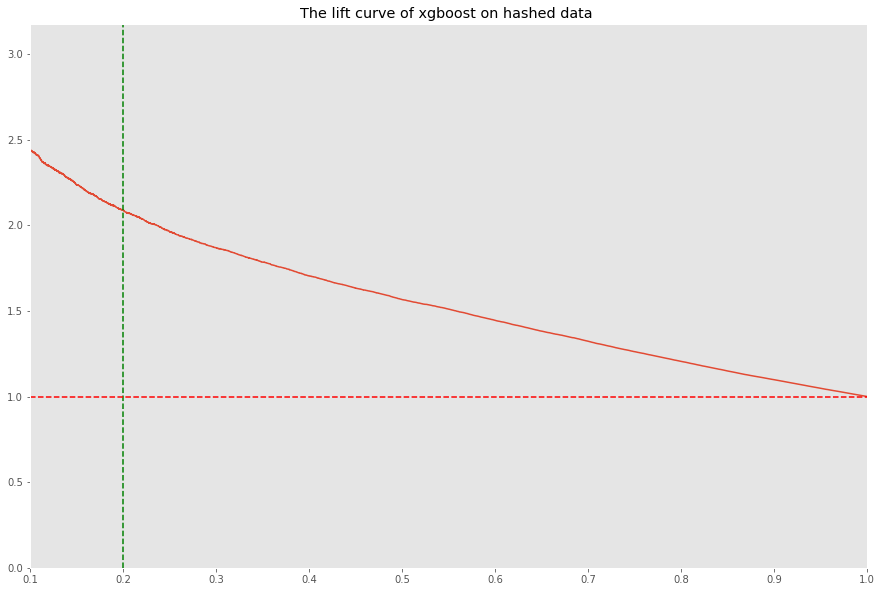

In [116]:
# Plot the lift curve here
plt.figure(figsize=(15,10))
plt.style.use("ggplot")
plotlift(ytest, soft.T[1])
# The following line just plots a vertical line for you to answer the second part of the question
plt.axvline(x= 0.2 , linestyle='--', color='g')
plt.axhline(y= 1 , linestyle='--', color='r');
plt.title("The lift curve of xgboost on hashed data ")

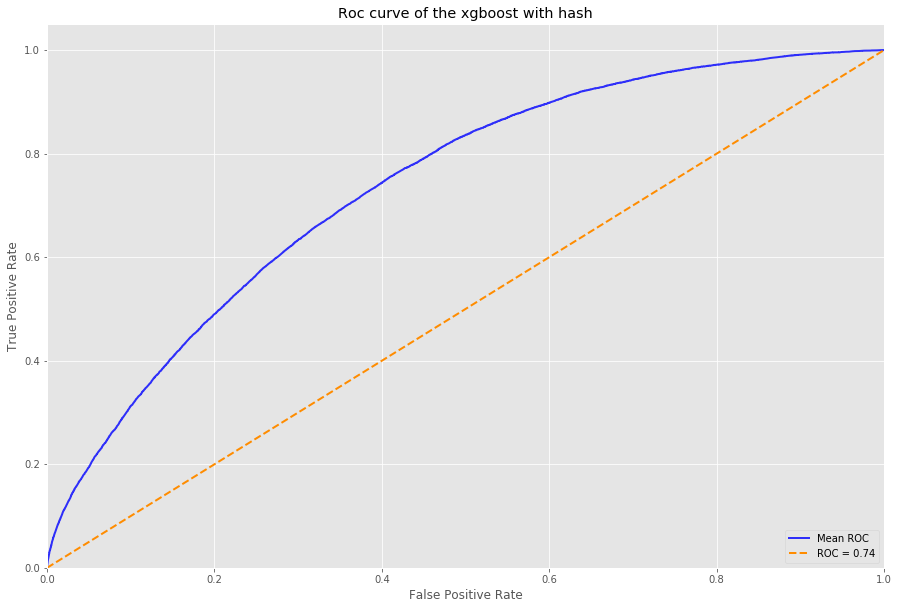

In [117]:
# Plot the ROC curve here
#from ggplot import *
plt.figure(figsize=(15,10))

fpr, tpr, thresholds = roc_curve(ytest,soft[:,1])
roc_auc =auc(fpr, tpr)

plt.plot(fpr, tpr, color='b',
         label=r'Mean ROC',
         lw=2, alpha=.8)

plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--',label='ROC = %0.2f' % roc_auc_score(ytest, soft.T[1]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve of the xgboost with hash')
plt.legend(loc="lower right")
plt.show()



Here we can see that the area under curve of XGB is a bit larger than the area of the logistic regression.So the algorithms performs better


Hashing produces columns of integers arbitrarily ordered. One can wonder if adding more columns hashed in a different fashion would lead to better performance. 
<font color="red">**Question 54:**
    Add hashed columns by recursively hashing the previous ones: complete the following code. 
</font>

In [118]:
Xtrain_haha = pd.DataFrame(Xtrain_ha).copy()
Xtest_haha = pd.DataFrame(Xtest_ha).copy()

n_hash = 3
cols = Xtrain_ha.columns
for l in range(n_hash):
    for col in cols:
        Xtrain_haha[col + '-hash'] = Xtrain_haha[col].apply(  lambda x: hash(str(x))%1000000  )
        Xtest_haha[col + '-hash'] = Xtest_haha[col].apply(  lambda x: hash(str(x))%1000000  )
    cols = [col + '-hash' for col in cols]

<font color="red">**Question 55:**
    Evaluate the performance of a random forest and/or an xgboost clasifier on these enlarged dataset.
</font>

In [119]:

start_time = time.time()

xgb = XGBClassifier( n_estimators=1024, learning_rate = 0.1 ,njobs=-1,verbose=True)
%time xgb.fit(Xtrain_haha,y_train) 


end_time = time.time()

time_xgb_haha =(end_time - start_time)



CPU times: user 47min 16s, sys: 4.07 s, total: 47min 20s
Wall time: 47min 39s


In [120]:
############# evaluating the bewxgbclassifier ##########################
hard =xgb.predict(Xtest_haha)
soft = xgb.predict_proba(Xtest_haha)

print("The logloss of RandomForest with 1024 estimators  is  %.2f%%, the auc is %.2f%%" %(100*log_loss(ytest, soft[:,1]) ,100*roc_auc_score(ytest, soft[:,1])))

log_loss_xgb_haha=log_loss(ytest,soft[:,1])
auc_xgb_haha= roc_auc_score(ytest, soft[:,1])

The logloss of RandomForest with 1024 estimators  is  40.09%, the auc is 74.08%


We did not enhance significanly the performance  of the model and the metric remains stable regardless the different features engineering process  used 

<font color="red">**Question 55:**
    Compare the different models used in the TP.
</font>

Let's compare the different models based on the AUC and the log_loss

In [121]:
##### get all the scores 
logloss_models=[logloss_lr_1,log_loss_lr_new,log_los_xgbt,log_loss_lr_new_xgb,log_loss_xgbclassifier,log_loss_xgbclassifier_1024,log_loss_xgbclassifier_1024_learnrate,
log_loss_rf,log_loss_xgb_hash ,log_loss_xgb_haha]
auc_models=[auc_lr_1,auc_lr_new,auc_xgbt,auc_lr_new_xgb,auc_xgbclassifier,auc_xgbclassifier_1024,auc_xgbclassifier_1024_learnrate,auc_rf,auc_xgb_hash,auc_xgb_haha]
#time_models=[time_lr_1,time_lr_new,time_xgbt,time_lr_new_xgb,time_xgbclassifier,time_xgbclassifier_1024,time_xgbclassifier_1024_learnrate,time_rf,time_xgb_hash,time_xgb_haha]

NameError: name 'log_loss_xgbclassifier_1024' is not defined

In [140]:
##### combining the scores  into a dataframe
result=pd.concat([pd.DataFrame(auc_models),pd.DataFrame(logloss_models)],axis=1)
result.index=['lr_1','lr_new','xgbt','lr_new_xgb','xgbclassifier','xgbclassifier_1024','xgbclassifier_1024_learnrate','rf','xgb_hash','xgb_haha']
result.columns=["AUC","LOG_LOSS"]

In [141]:
result

,AUC,LOG_LOSS
lr_1,0.676241,0.425161
lr_new,0.736041,0.402793
xgbt,0.725244,0.409155
lr_new_xgb,0.737046,0.402565
xgbclassifier,0.724445,0.407897
xgbclassifier_1024,0.742571,0.399654
xgbclassifier_1024_learnrate,0.742571,0.399654
rf,0.740860,0.400943
xgb_hash,0.738029,0.402385
xgb_haha,0.741302,0.400631


We presented in the table above the scores of the different algorithms sorted chronologically :
* The scores based on AUC and log_loss are correlated .
* Except the simple logistic regression , the performance of all tested algorithms is globally similar
* The logisic regression does not give  good result unless processing and selecting the features using XGBoost
* tha XGB classifier with 1024 estimators  gives a far better results ,but it takes more time to run ( 12 min  VS 2 minutes for LR) . We tried three different learning rate ( 0.1 , 0.5 and 0.8) but this does not enhance the XGBCLASSIFIER score.
* Without tuning , The random forest gives a good score  but it remains less performant than xgboost with 1024 estimators , and it takes more time to train ( 24 min vs 12 min ) .
* The XGB with hashing and double hashing did not enhance the score  for our dataset

In term of performance and execution time , Logistic regression with xgboostfeature pocessing is a good choice for our problem 

## Conclusion


The Avazu CTR lab was clearly worth investing in as it provided a playing ground for methods, algorithms and libraries on a moderately big data set, with a multi-billion dollars business motivation. The lessons and insights learned here can be applied to similar click-through problems, as well as other time series events, such as web navigation logs analysis.

There are many well known methods that we did not implement in this lab and seem to be very promising like Matrix factorizaton and Vowpal Wabbit . We recall that Vowpal Wabbit is a large scale online learner, designed for learning from large datsets as it only reads a fraction of training examples into memory at any point. It seems highly suited for this example as it can accomodate models becoming out-dated, dealing with divergence of distributions over time and unbounded features (you may constantly collect new categorical feature values). 
